## interbedding: a python function for stochastic modelling of the interbedding architectures
Dongfang Qu, University of Copenhagen

### Introduction
- Interbedding is common in geology, it occurs when beds of a particular lithology lie between or alternate with beds of a different lithology. It often reflects a cyclical change in sedimentary conditions, e.g. sea level variations. 

- I developed this stochastic interbedding modelling function for generating multiple realizations of interbedded chalk and flint layers, in which the thickness of the chalk layers bounded by the flint bands varies laterally while the thickness of flint bands is constant. This function can be adapted to model other interbedding cases, such as the interbedding of limestone and marl layers, the interbedding of sandstone and shale layers.

- User specified input parameters include: 2D model size and resolution, mean and standard deviation of the thickness distribution for lithology_1 (chalk in my case), and variogram range which describes the lateral variation of the thickness 

- The output is a 2D matrix with 0s indicating lithology_1(chalk in my case) and 1s indicating lithology_2(flint bands in my case)

### Method

- Strategy: Model the thickness of each chalk layer between two flint bands using variogram-based geostatistical modelling method(Janson and Madriz, 2012). Add flint layers on top of each chalk layer. 

- Psudocode: Make a zero matrix, replace some of the zeros with flint indicator; Positions of the zeros to be replaced  = accumulated thickness of chalk layers + accumulated thickness of flint layers.

- GeostatsPy (reimplementation of GSLIB in python, https://github.com/GeostatsGuy/GeostatsPy) is used for performing the Sequential Gaussian Simulation. 


### Load libraries

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import random as rand
import geostatspy_functions as gf                        #  geostatspy_functions.py, saved in the same directory                                                       

### Function

I saved the geostatspy functions(https://github.com/GeostatsGuy/GeostatsPy/blob/master/examples/GeostatsPy_Testing.ipynb) as a .py file and import it at the beginning of the Python workflow. 

The executables associated with the functions should be in the current working directory. These include GSLIB programs, which can be downloaded from gslib.com. Please refer to https://github.com/GeostatsGuy/GeostatsPy for more details.

- nscore.exe
- declus.exe
- gam.exe
- gamv.exe
- vmodel.exe
- kb2d.exe
- sgsim.exe

In [2]:
def interbedding (nx,ny, cell_size, mean, stdev, hmin, hmax):
    '''return a 2D array composed of 0s (lithofacies_1, e.g. chalk layer ) 
    and 1s (lithofacies_2, e.g. flint layers) 
    :nx: number of cells in the x-direction, i.e. number of columns
    :ny: number of cells in the y-direction, i.e. number of rows
    :accu: accumulated thickness of litholoy_1, in number of cells
    :mean, stdev: mean and standard deviation of thickness of lithology_1, or spacing between lithology_2
    :hmin, hmax: variogram range of thickness distribution is a random number between hmin and hmax, in meter
    '''
    model = np.zeros ((ny,nx))
    accu = np.zeros((ny,))     # accumulated thickness
    
    for i in range(int(ny*cell_size/mean)):
        h = rand.randint(hmin,hmax)    # variogram range, a random value between hmin and hmax, in meter 
        var = gf.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90,hmaj1=h,hmin1=ny*cell_size/10) # variogram for stochastic simulation
        seed = rand.randint(1000,2000)  # random number seed  for stochastic simulation   
        thickness = gf.GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,var,"Thickness") # Make a unconditional simulation
        thickness = gf.affine(thickness,mean,stdev)
        accu += thickness[1]/cell_size   #transform thickness in meter to number of cells
        for count, value in enumerate(accu):
            if value <= ny:
                model[199-int(value),count] = 1 # replace some 0s with 1s
        accu += 1
    
    plt.figure(figsize=(12, 12))
    plt.imshow(model)  
    plt.xticks(np.arange(0,nx,step=(1/cell_size)*int((nx*cell_size)/10)),np.arange(0, int(nx*cell_size), step= int((nx*cell_size)/10)))  # set positions and labels for x-axis
    plt.yticks(np.arange(0,ny,step=(1/cell_size)*int((ny*cell_size)/10)),np.arange(0, int(ny*cell_size), step= int((ny*cell_size)/10)))
    np.savetxt('model.csv',model)

### Examples
#### Case 1: Interbedded chalk and flint bands, short variogram range
- It can be seen that with a shorter variogram range (20-30m) and a larger standard deviation (1.5), the thickness of the chalk layers between the flint bands are more variable. The flint bands occur as discontinuous nodules in this case, which is consistent with what observed from the outcrops.
- with the same input, each run generate a unique realization

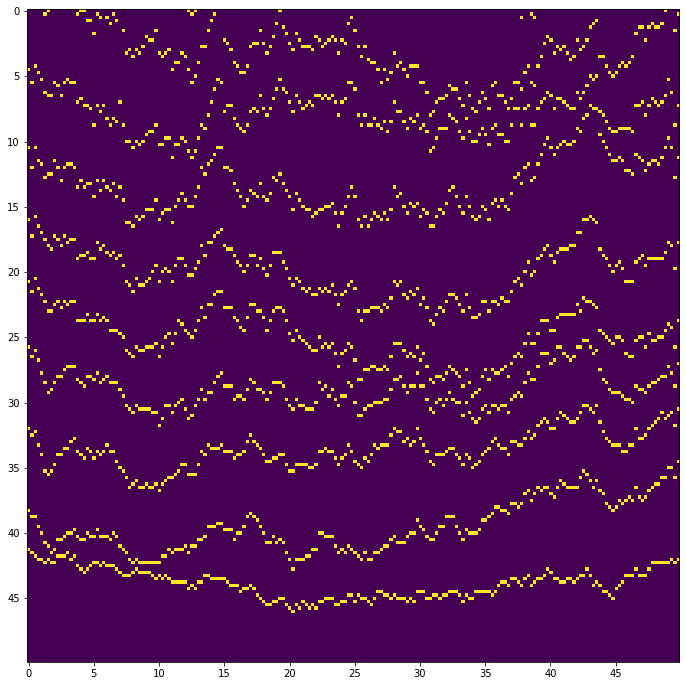

In [3]:
# run the function
interbedding (nx=200,ny=200, cell_size=0.25, mean=5, stdev=1.5, hmin=20, hmax=30)

#### Case 2: Interbedded chalk and flint bands, long variogram range
With a long variogram range (200-300m), and a smaller standard variation (0.5), the thickness of chalk layers between the flint bands are less variable. 

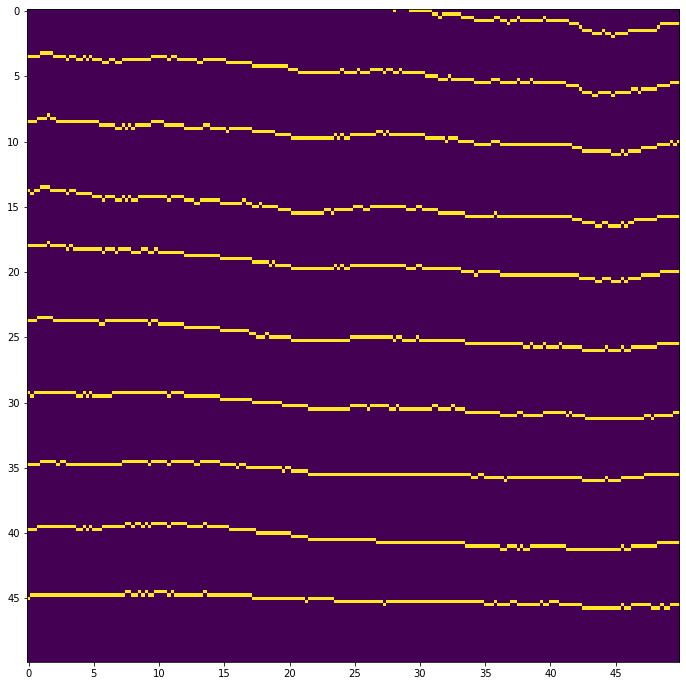

In [4]:
# run the function
interbedding (nx=200,ny=200, cell_size=0.25, mean=5, stdev=0.5, hmin=200, hmax=300)

### References
- Pyrcz, M. GeostatsPy. https://github.com/GeostatsGuy/GeostatsPy/blob/master/examples/GeostatsPy_Testing.ipynb
- Janson, X. and Madriz, D.D., 2012. Geomodelling of carbonate mounds using two-point and multipoint statistics. Geological Society, London, Special Publications, 370(1), pp.229-246.